<a id="0"></a>
# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#000000; font-size:140%; text-align:center;padding: 0px; border-bottom: 0px solid #000000">Audio Machine Learning</p>
## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#000000; font-size:140%; text-align:center;padding: 0px; border-bottom: 3px solid #000000">Load Process and Stream</p>

**AUTHOR - SUJAY KAPADNIS**

**DATE - 25/07/2023**

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#3f1ce3; font-size:140%; text-align:left;">Index</p>
1. [Introduction](https://www.kaggle.com/code/sujaykapadnis/audio-machine-learning-for-speech-recog-intro/notebook)
2. Loading, Preprocessing and Streaming

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#3f1ce3; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #3f1ce3">Installation and Importing Stuff</p>


In [1]:
# pip install datasets[audio] 

In [2]:
import matplotlib.pyplot as plt
import IPython.display as ipd
from datasets import Audio
import numpy as np
%matplotlib inline
import librosa
import random

# for prepocessing steps
from transformers import WhisperFeatureExtractor
from transformers import AutoProcessor

In [3]:
from datasets import load_dataset
minds = load_dataset('PolyAI/minds14',name = 'en-AU',split = 'train')
# if you want to use another language - https://huggingface.co/datasets/PolyAI/minds14/viewer
minds

Generating train split: 0 examples [00:00, ? examples/s]

Dataset minds14 downloaded and prepared to /root/.cache/huggingface/datasets/PolyAI___minds14/en-AU/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696. Subsequent calls will reuse this data.


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [4]:
example = minds[0]
example

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ], dtype=float32),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [5]:
audio,sr = librosa.load(example['path'])
print("Transcription:", example['english_transcription'])
ipd.display(ipd.Audio(audio, rate=sr))

Transcription: I would like to pay my electricity bill using my card can you please assist


In [6]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

WE don't need, language id and english transcription if we intend to train the transformer

In [7]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [8]:
random_indices = [91,84,21,55,50,61]
print(random_indices)

for idx in random_indices:
    audio_file_path = minds[idx]['path']

    # Load the audio file using librosa
    audio, sr = librosa.load(audio_file_path, sr=None)

    # Print the transcription and play the audio
    print("Transcription:", minds[idx]['transcription'])
    print("Topic: ",id2label(minds[idx]['intent_class']))
    ipd.display(ipd.Audio(audio, rate=sr))

[91, 84, 21, 55, 50, 61]
Transcription: I like to enquire about cancelling also freezing all transactions on my account on my card thanks you can help
Topic:  freeze


Transcription: I need to freeze my card
Topic:  freeze


Transcription: I have a builder Bay and I'm running late for my payment
Topic:  pay_bill


Transcription: please freeze my card
Topic:  freeze


Transcription: I would like to stop all transactions and freeze my credit card
Topic:  freeze


Transcription: hi I'm just calling because ID like to freeze all transactions on my
Topic:  freeze


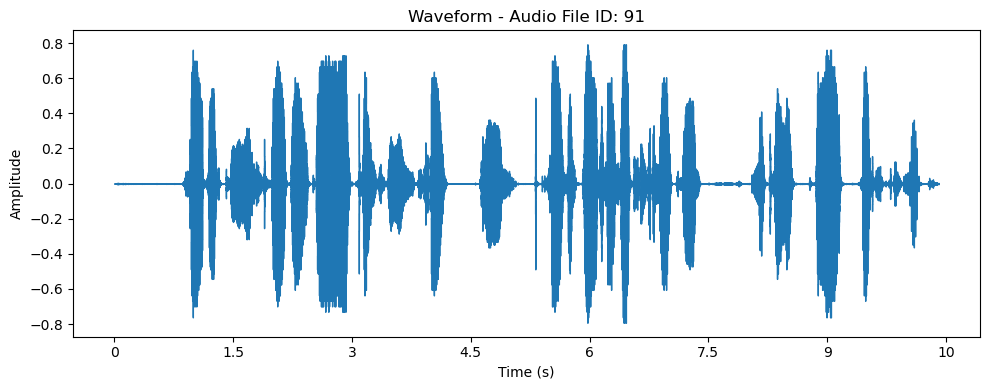

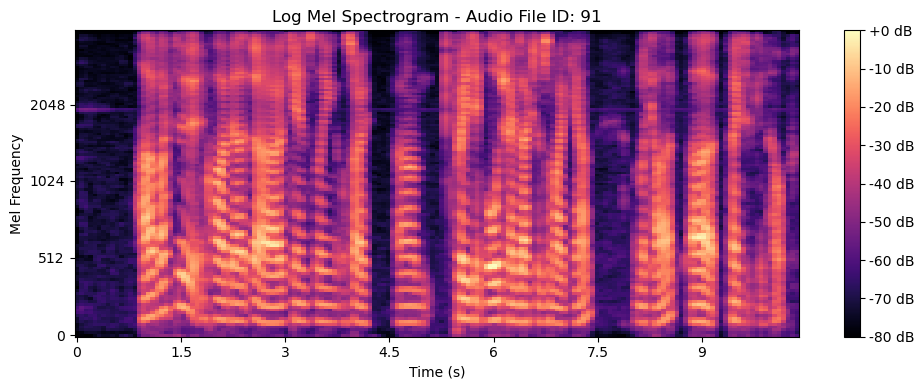

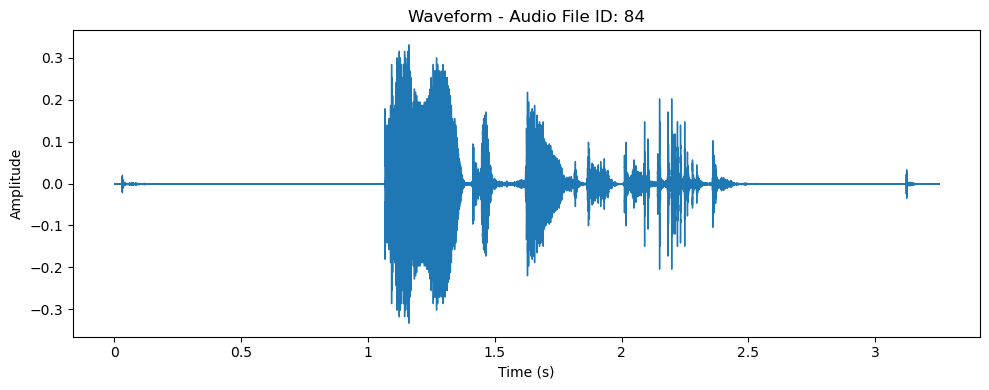

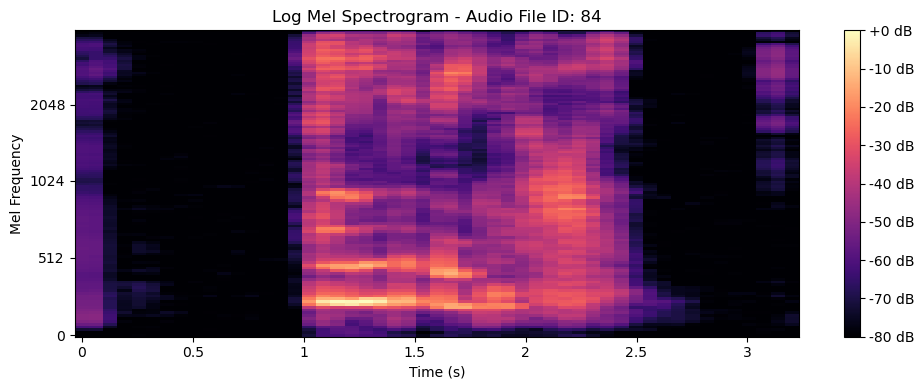

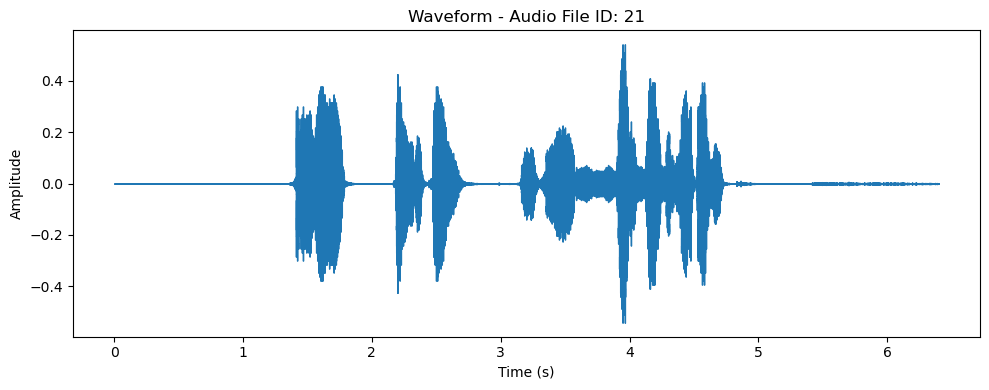

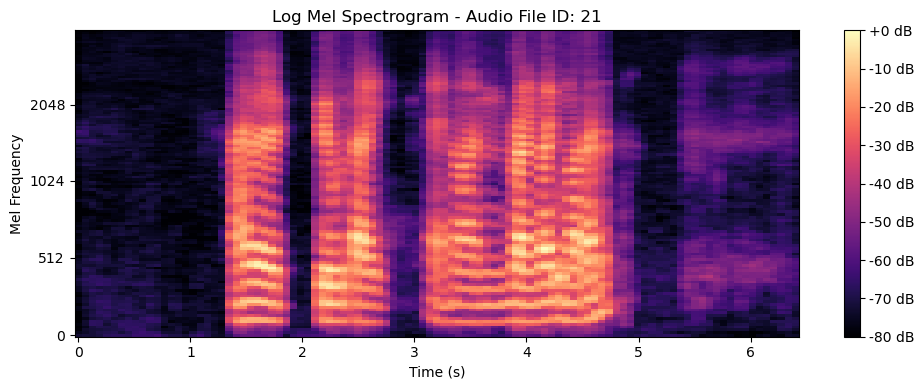

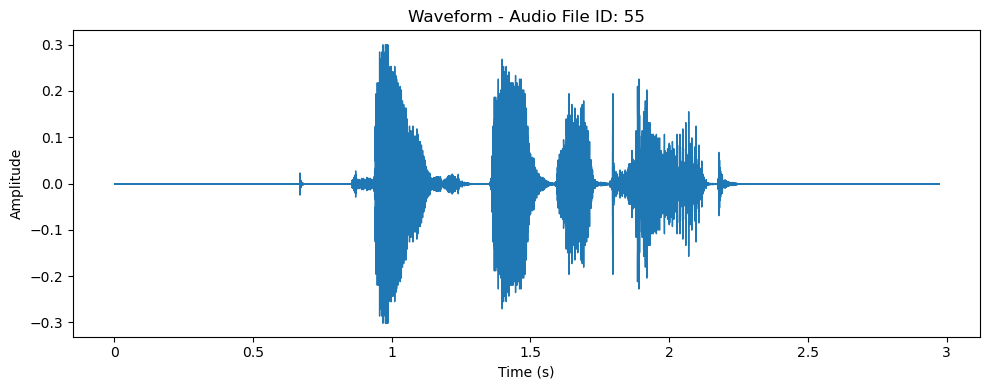

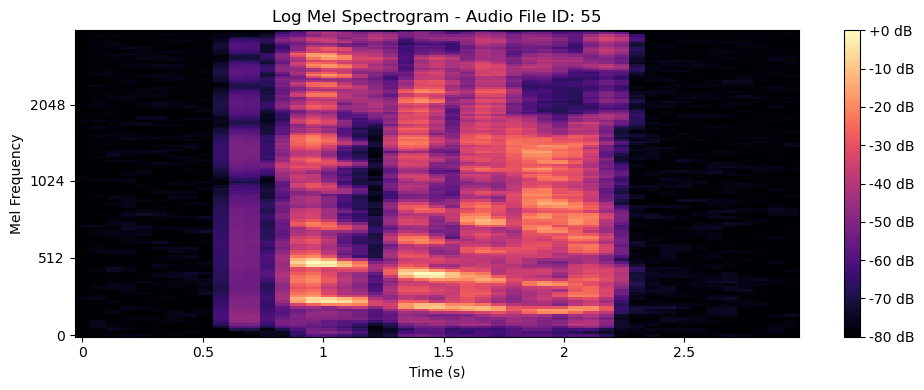

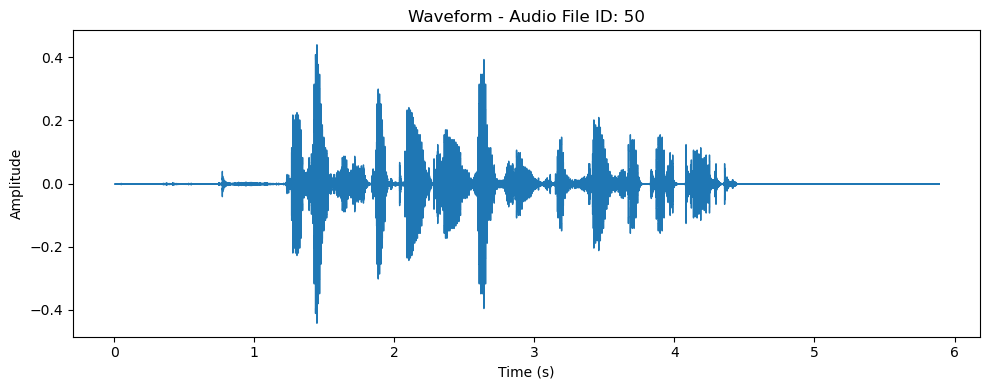

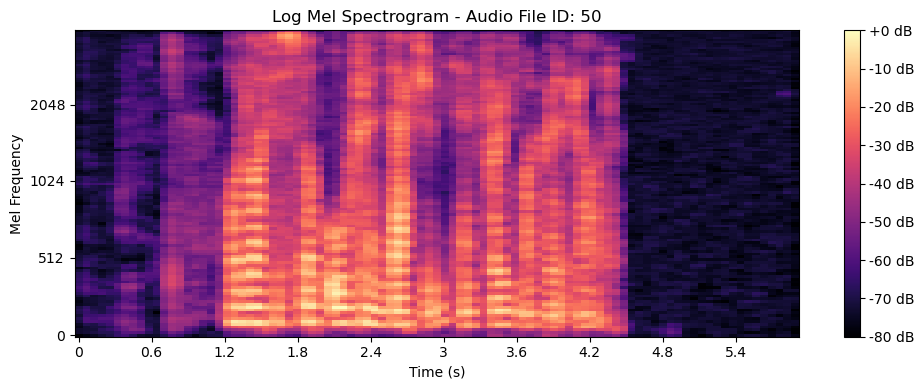

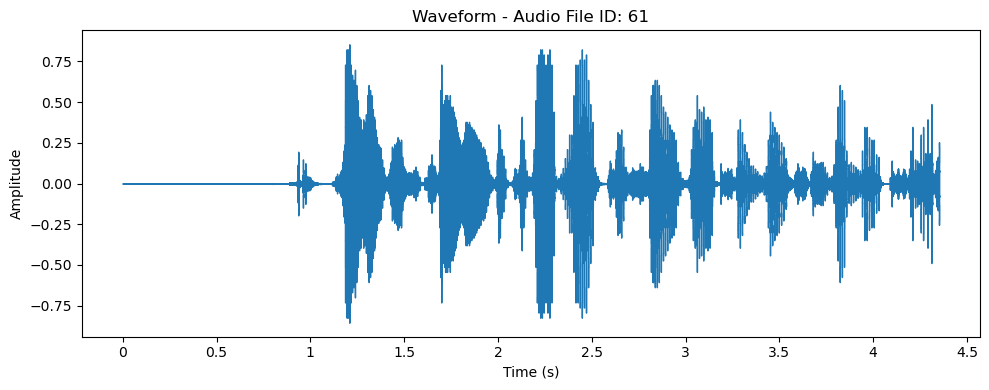

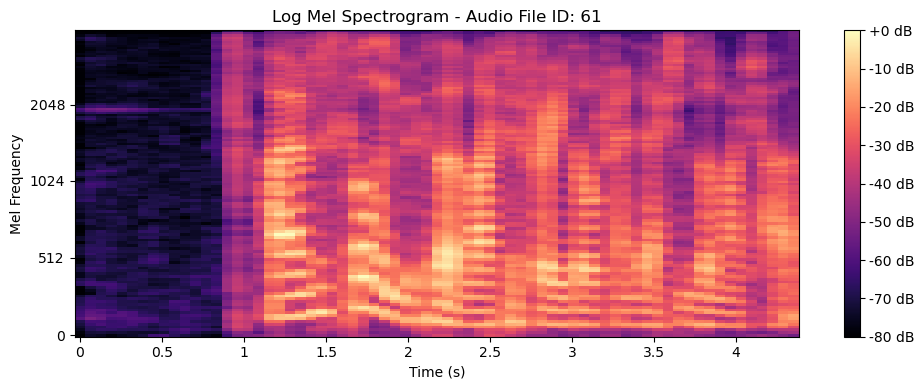

In [9]:
for idx in random_indices:
    audio_file_path = minds[idx]['path']

    # Load the audio file using librosa
    audio, sr = librosa.load(audio_file_path, sr=None)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f"Waveform - Audio File ID: {idx}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # Plot the log Mel spectrogram
    plt.figure(figsize=(10, 4))
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Log Mel Spectrogram - Audio File ID: {idx}")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#3f1ce3; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #3f1ce3">Preprocess</p>
**Steps**
1. Resampling
- Most of the pretrained models have sampling rate of 16KHz and we noticed that our data has 8KHz
2. Filtering - 
 - some filtering techniques
  - based on their audio length

In [10]:
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds[0]['audio']['sampling_rate']

16000

In [11]:
print(len(example['audio']['array']))
print(len(minds[0]['audio']['array']))

62415
124830


- since we have doubled the sampling rate, length of the array also has doubled because we are now taking 2 sample between the same interval where we were taking only 1
-  Upsampling to a higher sampling rate is then a matter of calculating additional sample values that go in between the existing ones,
- Downsampling, however, requires that we first filter out any frequencies that would be higher than the new Nyquist limit, before estimating the new sample points.
- Nyquist limit frequency is equal to sampling rate / 2          (refer previous notebook)
- Downsampling cannot be done by removing alternate samples, neither by averaging them
- If we did downsample like that then distortions are created called as aliases

In [12]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [13]:
# since we do not have any key related to duration of audio, we create
duration = [librosa.get_duration(path = x) for x in minds['path']]
minds = minds.add_column('duration',duration)

# now apply the filter
minds = minds.filter(is_audio_length_in_range,input_columns = ['duration'])

# now that we have filtered the data, remove that column
minds = minds.remove_columns(['duration'])

  0%|          | 0/1 [00:00<?, ?ba/s]

- WE can either train the model either from scratch or use a pretrained model for inference. 
- IN any case it's important we preprocess the data to feed into our model
- FOR pretrained model it should be in the format as of the data it was (pre)trained on.

- WE will use FeatureExtractors to do that. i.e. convert raw data into something the model exptects

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#3f1ce3; font-size:140%; text-align:left;padding: 0px;">whisper</p>
Whisper is a pretrained Model for speech recognition, released last year by OPENAi, we will see functionality of its feature extractor
- pad(if <) or truncates(if >) the audio samples - 30s - (padded by 0s)
- whisper does not use attention mask like other models
- <span style="color: blue;">Attention Mask</span>
  - it's a binary mask applied during attention mask to help identify original data and padded/truncated
  - during attention mechanism every element gets an attention score and AM assigns this score to -inf for padded values

In [14]:
FE = WhisperFeatureExtractor.from_pretrained('openai/whisper-small')

In [15]:
def prepare_dataset(example):
    audio = example['audio']
    features = FE(
    audio['array'],sampling_rate = audio['sampling_rate'],padding = True)
    return features

In [16]:
minds = minds.map(prepare_dataset)
minds

  0%|          | 0/624 [00:00<?, ?ex/s]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

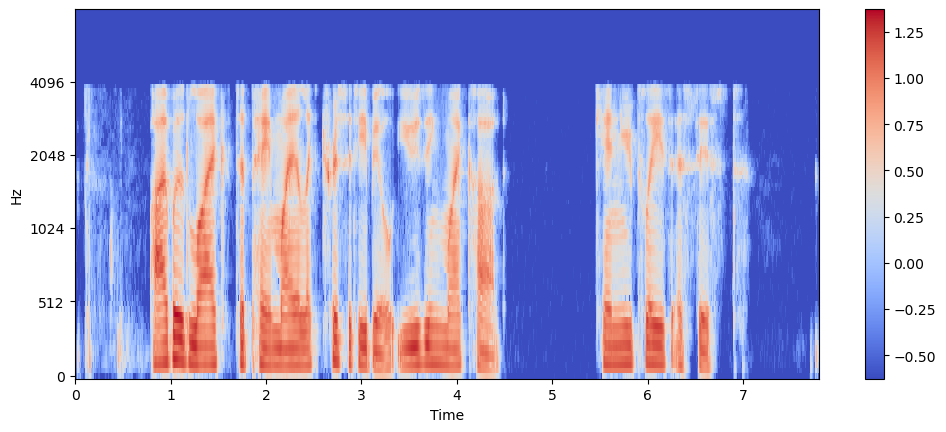

In [17]:
example = minds[0]
input_features = example['input_features']
plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis = 'time',
    y_axis = 'mel',
    sr = FE.sampling_rate,
    hop_length = FE.hop_length)
plt.colorbar()

In [18]:
processor = AutoProcessor.from_pretrained("openai/whisper-small")

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#3f1ce3; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #3f1ce3">Problems with Audio Data</p>
- We mostly face storage problem in case of audio data and it is almost impossible to load it entirely in the memory.
- Solution to this is to load one example at a time, the so called streaming
- IN such way you load and process on the fly
- Drawback of this method being, it's done temporarily so if you want to use it multiple times, prefer to have the data locally


In [19]:
minds = load_dataset('PolyAI/minds14',name = 'en-AU',split = 'train', streaming=True)

In [20]:
minds

In [21]:
sample = minds.take(2)

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#3f1ce3; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #3f1ce3">Link to next notebook</p>
[Building Pipelines](https://www.kaggle.com/code/sujaykapadnis/audio-ml-building-pipelines)

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#3f1ce3; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #3f1ce3">Reference</p>
[HuggingFace](https://huggingface.co/learn/audio-course/chapter1/audio_data)

[AudioSignalProcessingForML](https://github.com/musikalkemist/AudioSignalProcessingForML)

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#3f1ce3; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #3f1ce3">Music I listened to while studying this</p>
[Babam Bam](https://youtu.be/9KCtZ9r4OAw)

<a id="0"></a>
# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#000000; font-size:140%; text-align:center;padding: 0px; border-bottom: 0px solid #000000">Have a lovely week ahead and don't forget to UPVOTE</p>
